In [3]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from alfi.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from alfi.utilities.torch import inv_softplus, softplus
from alfi.datasets import DeterministicLotkaVolterra
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.configuration import VariationalConfiguration
from alfi.trainers import VariationalTrainer

import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

Num training points:  13


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

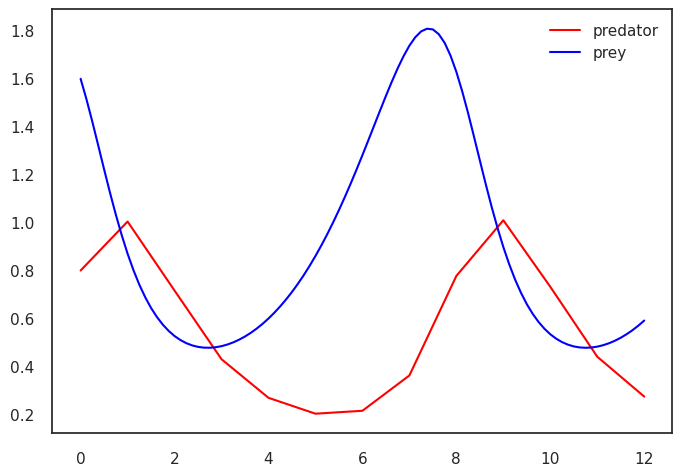

In [4]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=0.8,
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]
num_inducing = 20

print('Num training points: ', num_training)
output_names = np.array(['pred','prey'])

In [14]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 1.5)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        print(dataset.prey[::3].shape)
        self.true_f = dataset.prey[::3].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        # print(t, self.t_index, self.f.shape, self.true_f.shape)
        # f shape (num_samples, num_outputs, num_times)
        f = self.f[:, :, self.t_index].unsqueeze(2)
        # f = self.true_f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
    
        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)


tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([33])
torch.Size([70, 1, 33])


/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/alfi/models/variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the f

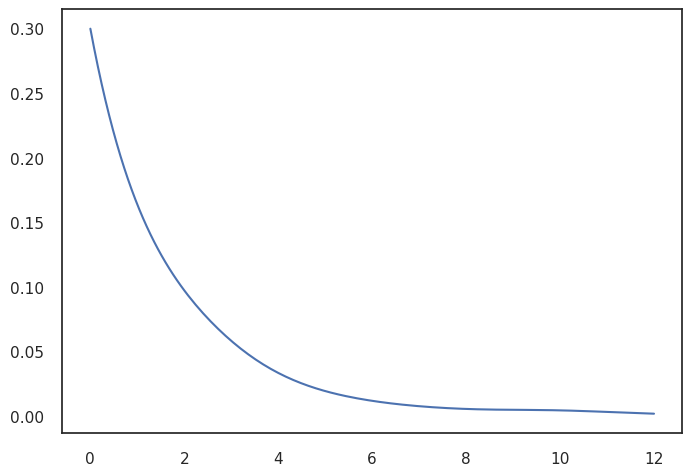

In [15]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(
    num_latents, num_inducing, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
with torch.no_grad():
    mean_module.constant -= 0.2
track_parameters = ['raw_growth', 'raw_decay']

if periodic:
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
        batch_shape=torch.Size([num_latents])
    )  # * \
    # gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))

    print(covar_module.base_kernel.period_length)
    covar_module.base_kernel.lengthscale = 3
    covar_module.base_kernel.period_length = 8
    track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')
    track_parameters.append('gp_model.covar_module.base_kernel.raw_period_length')
    # covar_module.kernels[1].lengthscale = 2
else:
    covar_module = gpytorch.kernels.RBFKernel(
        batch_shape=torch.Size([num_latents]),
        lengthscale_constraint=Interval(1, 6))
    covar_module.lengthscale = 2
    track_parameters.append('gp_model.covar_module.raw_lengthscale')

gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, num_latents,
                         natural=use_natural)

    # print(covar_module.base_kernel.kernels)
    # covar_module.base_kernel.kernels[0].lengthscale = 3
    # covar_module.base_kernel.kernels[0].period_length = 8
    # covar_module.base_kernel.kernels[1].lengthscale = 2

lfm = LotkaVolterra(num_outputs, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))

out = lfm(t_predict, step_size=1e-2)
plt.plot(t_predict, out.mean.detach())


In [9]:
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=50,
    track_parameters=track_parameters
)

In [12]:
a = trainer.train(1000, report_interval=10, step_size=1/3)


Epoch 101/1100 - Loss: 0.80 (0.79 0.00) kernel: [2.8196802]
Epoch 111/1100 - Loss: 0.77 (0.77 0.00) kernel: [2.8207414]
Epoch 121/1100 - Loss: 0.74 (0.74 0.00) kernel: [2.821988]
Epoch 131/1100 - Loss: 0.72 (0.72 0.00) kernel: [2.8239946]
Epoch 141/1100 - Loss: 0.98 (0.97 0.01) kernel: [2.8052585]
Epoch 151/1100 - Loss: 0.75 (0.72 0.04) kernel: [2.7710986]
Epoch 161/1100 - Loss: 0.76 (0.72 0.03) kernel: [2.7601037]
Epoch 171/1100 - Loss: 0.74 (0.71 0.02) kernel: [2.7568347]
Epoch 181/1100 - Loss: 0.72 (0.71 0.02) kernel: [2.7565506]
Epoch 191/1100 - Loss: 0.71 (0.70 0.01) kernel: [2.7573578]
Epoch 201/1100 - Loss: 0.69 (0.68 0.01) kernel: [2.7581806]
Epoch 211/1100 - Loss: 0.67 (0.67 0.01) kernel: [2.7554677]
Epoch 221/1100 - Loss: 0.64 (0.63 0.01) kernel: [2.743546]
Epoch 231/1100 - Loss: 0.63 (0.63 0.01) kernel: [2.735554]
Epoch 241/1100 - Loss: 0.68 (0.64 0.04) kernel: [2.6917186]
Epoch 251/1100 - Loss: 0.69 (0.65 0.05) kernel: [2.6680677]
Epoch 261/1100 - Loss: 0.67 (0.63 0.04) ker

findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Generic family 'serif' not found because none of the f

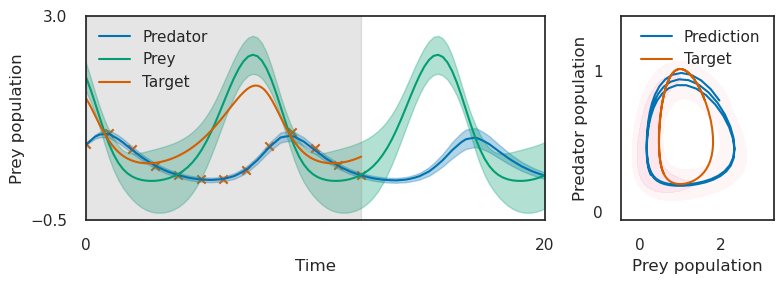

In [13]:
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.5, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].plot(dataset.times, dataset.prey, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1])
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
axes[1].set_yticks([0, 1])
plt.tight_layout()
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
plt.savefig('./periodic-combined.pdf', **tight_kwargs)